# Custom ViT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setting up the MLFlow ui

In [ ]:
!pip install mlflow --quiet
!pip install pyngrok --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.8/731.8 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import mlflow
import subprocess
from pyngrok import ngrok, conf
import getpass

In [ ]:
MLFLOW_TRACKING_URI = "file:///content/drive/MyDrive/my_model/mlruns/"
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", MLFLOW_TRACKING_URI])

<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', 'file...>

In [ ]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("vanila-vit-model")

<Experiment: artifact_location='file:///content/drive/MyDrive/my_model/mlruns/357267894578507686', creation_time=1700942233894, experiment_id='357267894578507686', last_update_time=1700942233894, lifecycle_stage='active', name='vanila-vit-model', tags={}>

In [ ]:
print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
conf.get_default().auth_token = getpass.getpass()
port=5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\"')

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth
··········


 * ngrok tunnel "https://c706-35-192-169-193.ngrok-free.app" -> "http://127.0.0.1:5000"


## Code for Vanila- VIT

In [ ]:
!unzip drive/MyDrive/DATASET.zip
!unzip drive/MyDrive/going_modular.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/DATASET/TRAIN/Recyclable/._R_7746.jpg  
  inflating: DATASET/TRAIN/Recyclable/R_8475.jpg  
  inflating: __MACOSX/DATASET/TRAIN/Recyclable/._R_8475.jpg  
  inflating: DATASET/TRAIN/Recyclable/R_1323.jpg  
  inflating: __MACOSX/DATASET/TRAIN/Recyclable/._R_1323.jpg  
  inflating: DATASET/TRAIN/Recyclable/R_7752.jpg  
  inflating: __MACOSX/DATASET/TRAIN/Recyclable/._R_7752.jpg  
  inflating: DATASET/TRAIN/Recyclable/R_8461.jpg  
  inflating: __MACOSX/DATASET/TRAIN/Recyclable/._R_8461.jpg  
  inflating: DATASET/TRAIN/Recyclable/R_3534.jpg  
  inflating: __MACOSX/DATASET/TRAIN/Recyclable/._R_3534.jpg  
  inflating: DATASET/TRAIN/Recyclable/R_5145.jpg  
  inflating: __MACOSX/DATASET/TRAIN/Recyclable/._R_5145.jpg  
  inflating: DATASET/TRAIN/Recyclable/R_5623.jpg  
  inflating: __MACOSX/DATASET/TRAIN/Recyclable/._R_5623.jpg  
  inflating: DATASET/TRAIN/Recyclable/R_3252.jpg  
  inflating: __MACOSX/DATASET/TRAIN/Recyclabl

In [ ]:
!cp drive/MyDrive/helper_functions.py .

In [ ]:
import torchinfo

torchinfo.__version__

'1.8.0'

In [ ]:
!python --version

Python 3.10.12


In [ ]:
import torch
torch.__version__

'2.1.0+cu118'

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Setup directory paths to train and test images
train_dir = '/content/DATASET/TRAIN'
test_dir = '/content/DATASET/TEST'

In [ ]:
# Code which I tried to use ClearML:
# from clearml import Task
# task = Task.init(project_name="ML-project", task_name="vit-vanilla")
# logger = task.get_logger()

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Class names
  class_names = train_data.classes

  # Data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [ ]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [ ]:
BATCH_SIZE = 64

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b3ed964d6c0>,
 ['Organic', 'Recyclable'])

torch.Size([3, 224, 224]) tensor(0)


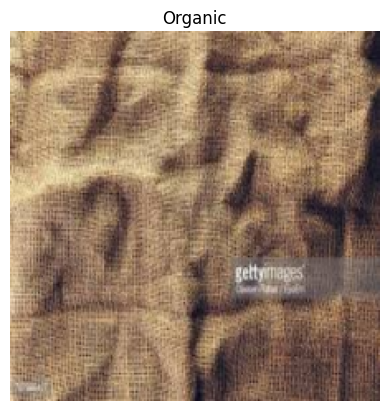

In [ ]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]

print(image.shape, label)

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [ ]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    """
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        return x_flattened.permute(0, 2, 1)

In [ ]:
# Testing the code
patch_size =16

def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)



set_seeds()

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [ ]:
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.6587,  0.1294, -0.2012,  ...,  0.4916, -0.2794,  0.2792],
         [-0.5718,  0.0450, -0.0838,  ...,  0.3303, -0.2734,  0.2018],
         [-0.6441,  0.1192, -0.0984,  ...,  0.4319, -0.3044,  0.1860],
         ...,
         [-0.4075,  0.0766, -0.1180,  ...,  0.1588, -0.1667,  0.1245],
         [-0.3052,  0.0111, -0.1343,  ...,  0.1870, -0.1103,  0.2494],
         [-0.3195,  0.0880, -0.0801,  ...,  0.2117, -0.1915,  0.1172]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
set_seeds()

patch_size = 16

print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

print(patch_embedding_class_token)

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.6587,  0.1294, -0.2012,  ...,  0.4916, -0.2794,  0.2792],
         [-0.5718,  0.0450, -0.0838,  ...,  0.3303, -0.2734,  0.2018],
         ...,
         [-0.4075,  0.0766, -0.1180,  ...,  0.1588, -0.1667,  0.1245],
         [-0.3052,  0.0111, -0.1343,  ...,  0.1870, -0.1103,  0.2494],
         [-0.3195,  0.0880, -0.0801,  ...,  0.2117, -0.1915,  0.1172]]],
       grad_fn=<CatBackward0>)


In [ ]:
class MultiheadSelfAttentionBlock(nn.Module):
    """Multi-head self-attention block.
    """
    def __init__(self,
                 embedding_dim:int=768, 
                 num_heads:int=12, 
                 attn_dropout:float=0):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [ ]:
class MLPBlock(nn.Module):
    """Multilayer perceptron block."""
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [ ]:
class TransformerEncoderBlock(nn.Module):
    """Transformer Encoder block."""
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.1,
                 attn_dropout:float=0):
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    def forward(self, x):
        x =  self.msa_block(x) + x

        x = self.mlp_block(x) + x

        return x

In [ ]:
transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [ ]:
class ViT(nn.Module):
    """Vision Transformer architecture"""
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:float=0,
                 mlp_dropout:float=0.1,
                 embedding_dropout:float=0.1,
                 num_classes:int=1000): 
        super().__init__() 

        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        self.num_patches = (img_size * img_size) // patch_size**2

        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]

        class_token = self.class_embedding.expand(batch_size, -1, -1)

        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)

        x = self.position_embedding + x

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.classifier(x[:, 0])

        return x

In [ ]:
# Instantiate model class
vit = ViT(num_classes=len(class_names))

In [ ]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

import mlflow


def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    model.to(device)

    checkpoint_path = '/content/drive/My Drive/my_model/vit_model_10/model_checkpoint.pth'

    try:
      if torch.cuda.is_available():
          device = torch.device("cuda")
      else:
          device = torch.device("cpu")

      if torch.cuda.is_available():
          map_location = lambda storage, loc: storage.cuda()
      else:
          map_location = 'cpu'

      if torch.cuda.is_available():
          checkpoint = torch.load(checkpoint_path, map_location=map_location)
      else:
          checkpoint = torch.load(checkpoint_path, map_location=map_location)

      if 'epoch' in checkpoint:
          start_epoch = checkpoint['epoch'] + 1
          model.load_state_dict(checkpoint['model_state_dict'])
          optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      else:
          start_epoch = 0
    except FileNotFoundError:
      start_epoch = 0


    mlflow.end_run()
    
    # Train the model and save the training results to a dictionary
    with mlflow.start_run() as run:
      for epoch in tqdm(range(start_epoch, epochs)):
          train_loss, train_acc = train_step(model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            device=device)
          test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)

          print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
          )

          # Update results dictionary
          results["train_loss"].append(train_loss)
          results["train_acc"].append(train_acc)
          results["test_loss"].append(test_loss)
          results["test_acc"].append(test_acc)
          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict()}, checkpoint_path)
          log_epoch = epoch+1
          mlflow.log_metric("Epoch", log_epoch, step=log_epoch)
          mlflow.log_metric("train_loss", round(train_loss, 4), step=log_epoch)
          mlflow.log_metric("train_acc", round(train_acc, 4), step=log_epoch)
          mlflow.log_metric("test_loss", round(test_loss, 4), step=log_epoch)
          mlflow.log_metric("test_acc", round(test_acc, 4), step=log_epoch)

    return results


In [ ]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=0.0001, # previouis: lr=3e-3 Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.01) # 0.3: from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

results = train(model=vit,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=10,
                  device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5978 | train_acc: 0.7083 | test_loss: 0.4160 | test_acc: 0.8430
Epoch: 2 | train_loss: 0.4800 | train_acc: 0.7751 | test_loss: 0.3977 | test_acc: 0.8593
Epoch: 3 | train_loss: 0.4733 | train_acc: 0.7817 | test_loss: 0.4268 | test_acc: 0.8414
Epoch: 4 | train_loss: 0.4695 | train_acc: 0.7845 | test_loss: 0.3801 | test_acc: 0.8548
Epoch: 5 | train_loss: 0.4623 | train_acc: 0.7898 | test_loss: 0.3700 | test_acc: 0.8679
Epoch: 6 | train_loss: 0.4586 | train_acc: 0.7944 | test_loss: 0.3916 | test_acc: 0.8601
Epoch: 7 | train_loss: 0.4515 | train_acc: 0.7977 | test_loss: 0.3603 | test_acc: 0.8693
Epoch: 8 | train_loss: 0.4536 | train_acc: 0.7990 | test_loss: 0.3842 | test_acc: 0.8679
Epoch: 9 | train_loss: 0.4545 | train_acc: 0.7974 | test_loss: 0.3735 | test_acc: 0.8635
Epoch: 10 | train_loss: 0.4502 | train_acc: 0.7993 | test_loss: 0.3963 | test_acc: 0.8570


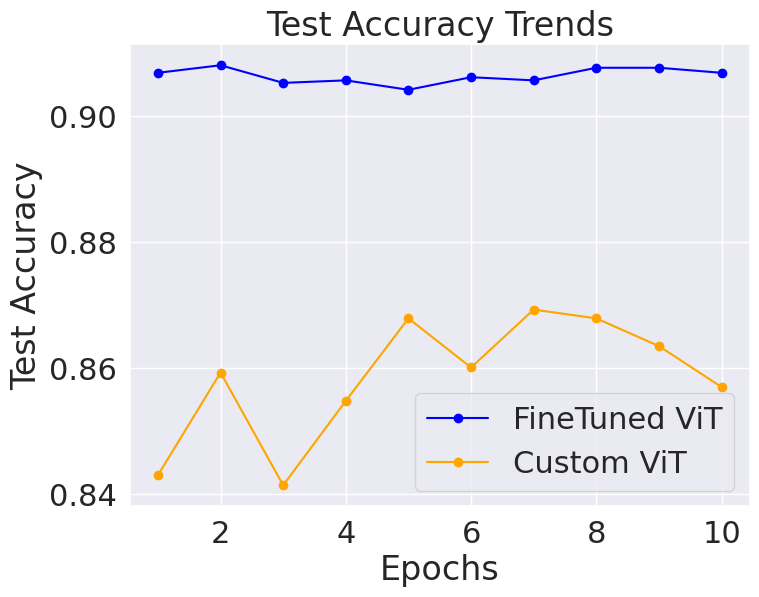

In [ ]:
import matplotlib.pyplot as plt

pretrained_test_acc = [0.9069, 0.9081, 0.9053, 0.9057, 0.9042, 0.9062, 0.9057, 0.9077, 0.9077, 0.9069]
custom_test_acc = [0.8430, 0.8593, 0.8414, 0.8548, 0.8679, 0.8601, 0.8693, 0.8679, 0.8635, 0.8570]

epochs = range(1, len(pretrained_test_acc) + 1)

plt.figure(figsize=(8, 6))
sn.set(font_scale=2.0)
plt.plot(epochs, pretrained_test_acc, marker='o', linestyle='-', color='blue', label='FineTuned ViT')
plt.plot(epochs, custom_test_acc, marker='o', linestyle='-', color='orange', label='Custom ViT')

plt.title('Test Accuracy Trends')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Inference code

In [ ]:
# Inference
import torch


checkpoint_path = '/content/drive/My Drive/my_model/vit_model/model_checkpoint.pth'

if torch.cuda.is_available():
    map_location = lambda storage, loc: storage.cuda()
else:
    map_location = 'cpu'

if torch.cuda.is_available():
    checkpoint = torch.load(checkpoint_path, map_location=map_location)
else:
    checkpoint = torch.load(checkpoint_path, map_location=map_location)

vit.load_state_dict(checkpoint['model_state_dict'])



<All keys matched successfully>

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

In [ ]:
#Confusion Matrix
y_pred = []
y_true = []

vit.to(device)
vit.eval()

test_loss, test_acc = 0, 0

with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dataloader):
    
        X, y = X.to(device), y.to(device)

        test_pred_logits = vit(X)

        test_pred_labels = test_pred_logits.argmax(dim=1)
        y_pred.extend(test_pred_labels)
        y_true.extend(y)


classes = ('Organic', 'Recyclable')

In [ ]:
cpu_pred = [t.cpu() for t in y_pred]
cpu_true = [t.cpu() for t in y_true]


numpy_array_pred = [t.numpy() for t in cpu_pred]
numpy_array_true = [t.numpy() for t in cpu_true]

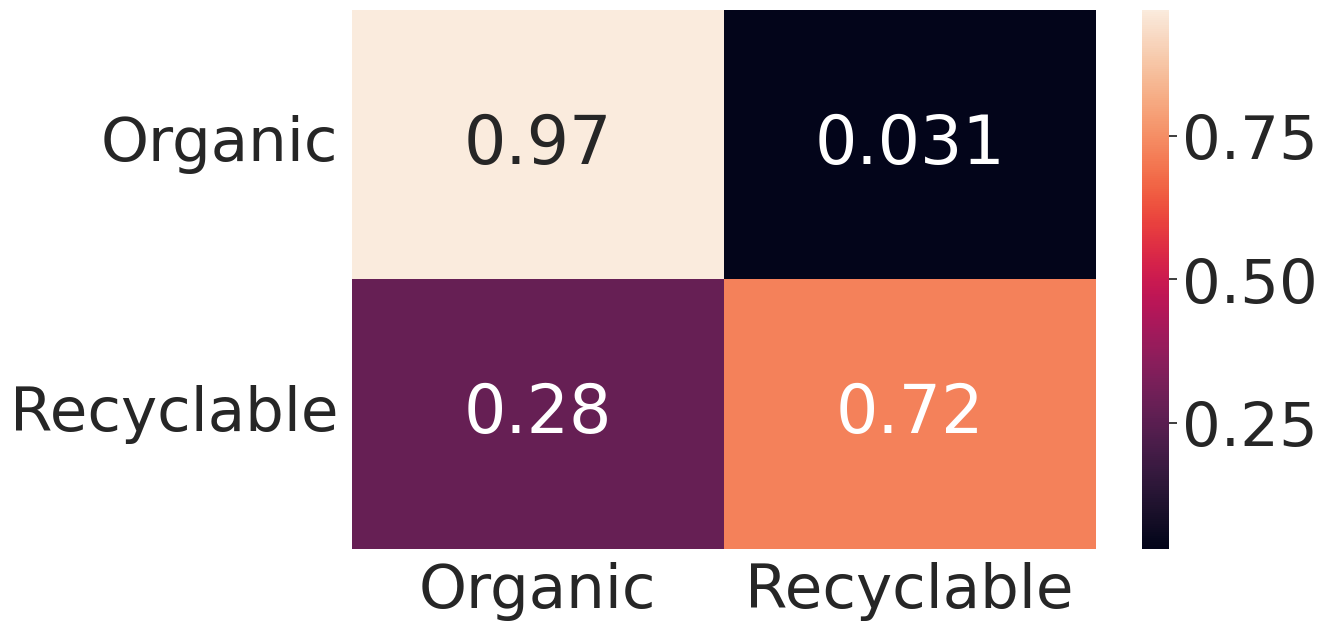

In [ ]:
# Build confusion matrix
cf_matrix = confusion_matrix(numpy_array_true, numpy_array_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.set(font_scale=4.0)
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [ ]:
# Calculate the precision
precision = cf_matrix[0, 0] / (cf_matrix[0, 0] + cf_matrix[0, 1])

# Calculate the recall
recall = cf_matrix[0, 0] / (cf_matrix[0, 0] + cf_matrix[1, 0])

# Calculate the F1 score
f1_score = 2 * precision * recall / (precision + recall)

print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1_score)

Precision: 0.9343326195574589
Recall: 0.8380281690140845
F1 score: 0.8835639554505568
